In [1]:
import os
import cv2
import numpy as np
import joblib
import albumentations as A
import tkinter as tk
from tkinter import filedialog, Label, Button
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

c:\Users\Sayal\AppData\Local\Programs\Python\Python310\lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
#  Data Augmentation
def augment_image(img):
    transform = A.Compose([
        A.RandomBrightnessContrast(p=0.3),
        A.Rotate(limit=30, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5)
    ])
    return transform(image=img)['image']

In [3]:
#  Feature Extraction
def extract_features(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (50, 50))
    img = augment_image(img)  # Apply augmentation
    features = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    return features.flatten().reshape(1, -1)


In [4]:
#  Load Dataset
def load_data(dataset_path="dataset/"):
    X, y = [], []

    # Ensure dataset folders exist
    for class_name in ["Non_Anemic", "Anemic"]:
        class_path = os.path.join(dataset_path, class_name)
        
        if not os.path.exists(class_path):
            print(f" Warning: Folder '{class_path}' not found. Creating it now.")
            os.makedirs(class_path)  # Create folder
            continue  # Skip processing empty folder

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            features = extract_features(img_path)  # Extract features
            X.append(features.flatten())  # Flatten features
            y.append(0 if class_name == "Non_Anemic" else 1)  # Assign label

    if len(X) == 0:
        raise ValueError(" No images found in dataset! Please add images to 'dataset/Non_Anemic' and 'dataset/Anemic'.")

    X, y = np.array(X), np.array(y)
    return train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
#  Train SVM Model
X_train, X_test, y_train, y_test = load_data("dataset/")  #  Corrected dataset path
model = svm.SVC(kernel='linear', probability=True)
model.fit(X_train, y_train)

c:\Users\Sayal\AppData\Local\Programs\Python\Python310\lib\site-packages\albumentations\core\validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


SVC(kernel='linear', probability=True)

In [6]:
#  Evaluate Model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f" Model Accuracy: {accuracy * 100:.2f}%")

 Model Accuracy: 61.54%


In [7]:
#  Save Model
joblib.dump(model, "anemia_svm_model.pkl")

['anemia_svm_model.pkl']

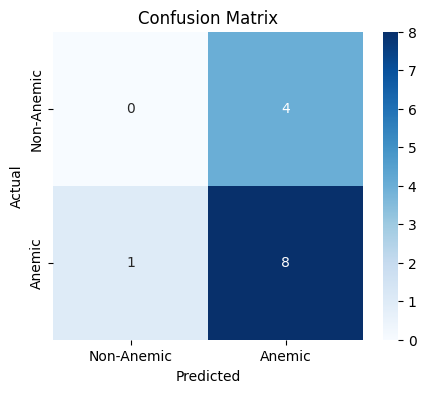

In [8]:
#  Confusion Matrix
def plot_confusion_matrix():
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=["Non-Anemic", "Anemic"],
                yticklabels=["Non-Anemic", "Anemic"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix()

In [9]:
#  GUI Application
class AnemiaDetectorApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Anemia Detection Using Eye Colour")
        self.root.geometry("500x400")
        self.root.configure(bg="#ffcccb")
        Label(self.root, text="Anemia Detection", font=("Arial", 18, "bold"), bg="#ff5733", fg="white").pack(pady=10)
        self.upload_btn = Button(self.root, text="Choose Eye Image", command=self.upload_image, 
                                 font=("Arial", 12), bg="#33cc33", fg="white", padx=10, pady=5)
        self.upload_btn.pack(pady=20)
        self.result_label = Label(self.root, text="", font=("Arial", 14), bg="#ffcccb", fg="black")
        self.result_label.pack(pady=10)
    
    def upload_image(self):
        file_path = filedialog.askopenfilename(filetypes=[("Image Files", "*.jpg;*.png;*.jpeg")])
        if file_path:
            self.predict_anemia(file_path)

    def predict_anemia(self, img_path):
        features = extract_features(img_path)
        model = joblib.load("anemia_svm_model.pkl")
        prediction = model.predict(features)[0]
        result_text = "Anemic" if prediction == 1 else "Non-Anemic"
        self.result_label.config(text=f"Prediction: {result_text}", fg="blue")


In [ ]:
#  Run GUI
root = tk.Tk()
app = AnemiaDetectorApp(root)
root.mainloop()


c:\Users\Sayal\AppData\Local\Programs\Python\Python310\lib\site-packages\albumentations\core\validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
